# Example for projective rendering given render matrix

In [1]:
import sys
sys.path.append("../ddsl")
from ddsl import DDSL_phys
from utils import normalize_V, readOBJ
import os
import numpy as np
import torch
from scipy.io import savemat
import trimesh
import matplotlib.pyplot as plt
%matplotlib inline

## Helper Functions

In [2]:
def project_mesh(input_trimesh, transform=None):
    """Project the mesh using the transformation matrix and ouput the V, E, D matrices for DDSL.
    
    Args:
      input_trimesh: 
    """
    if transform is not None:
        if not isinstance(transform, np.ndarray) and transform.shape == (4, 4):
            raise ValueError("transform must be None or an ndarray of shape (4, 4).")
        input_trimesh = input_trimesh.apply_transform(transform)  # Now z is the z-buffer.
    v_proj = input_trimesh.vertices[:, :-1]
    e_proj = input_trimesh.faces
    d_proj = np.ones([e_proj.shape[0], 1])
    return v_proj, e_proj, d_proj
    

def look_at(eye, center, world_up):
    """Computes camera viewing matrices (numpy implementation).

    Functionality mimes gluLookAt in Open GL.

    Args:
      eye: np.float32 array with shape [batch_size, 3] containing the XYZ world
        space position of the camera.
      center: np.float32 array with shape [batch_size, 3] containing a position
        along the center of the camera's gaze.
      world_up: np.float32 array with shape [batch_size, 3] specifying the
        world's up direction; the output camera will have no tilt with respect to
        this direction.
    Returns:
      A [batch_size, 4, 4] np.float32 array containing a right-handed camera
      extrinsics matrix that maps points from world space to points in eye space.
    """
    batch_size = center.shape[0]
    vector_degeneracy_cutoff = 1e-6
    forward = center - eye
    forward_norm = np.linalg.norm(forward, axis=1, keepdims=True)
    assert np.all(forward_norm > vector_degeneracy_cutoff)
    forward /= forward_norm

    to_side = np.cross(forward, world_up)
    to_side_norm = np.linalg.norm(to_side, axis=1, keepdims=True)
    assert np.all(to_side_norm > vector_degeneracy_cutoff)
    to_side /= to_side_norm
    cam_up = np.cross(to_side, forward)

    w_column = np.array(
        batch_size * [[0.0, 0.0, 0.0, 1.0]], dtype=np.float32
    )  # [batch_size, 4]
    w_column = w_column.reshape([batch_size, 4, 1])
    view_rotation = np.stack(
        [to_side, cam_up, -forward, np.zeros_like(to_side, dtype=np.float32)],
        axis=1,
    )  # [batch_size, 4, 3] matrix
    view_rotation = np.concatenate(
        [view_rotation, w_column], axis=2
    )  # [batch_size, 4, 4]

    identity_batch = np.tile(np.expand_dims(np.eye(3), 0), [batch_size, 1, 1])
    view_translation = np.concatenate(
        [identity_batch, np.expand_dims(-eye, 2)], 2
    )
    view_translation = np.concatenate(
        [view_translation, w_column.reshape([batch_size, 1, 4])], 1
    )
    camera_matrices = np.matmul(view_rotation, view_translation)
    return camera_matrices

def sigmoid_squash(inputs, alpha=2.5):
    """Use sigmoid to squash values to (0, 1).
    
    args:
      inputs: tensor to be squashed to (0, 1).
      alpha: scaling factor to adjust saturation. Larger alphas lead to more
        biased output values (closer to 0 and 1).
    """
    return torch.sigmoid(alpha * (inputs-1))

## Settings

In [3]:
# General settings.
device = "cpu"  # Backend. Alternatively can use "cuda" for GPU.
res = (128, 128)  # Render resolution.
mesh_file = "mesh/cow.obj"  # Name of mesh file to render.

# Render settings.
eye = (1., 1., 1.)  # Location of the camera eye.
center = (0., 0., 0.)  # Position along the center of the camera's gaze.
world_up = (0., 1., 0.)  # The up direction for world.

## Load and Render

In [4]:
# # Load mesh.
mesh = trimesh.load(mesh_file)

# Unsqeeze a "batch" dimension for eye, center, world_up
eye = np.array(eye)[None]
center = np.array(center)[None]
world_up = np.array(world_up)[None]
transform = look_at(eye, center, world_up)[0]

# Render silhouette.
v_proj, e_proj, d_proj = project_mesh(mesh, transform)
ddsl = DDSL_phys(res=res, t=[1]*2, j=2, elem_batch=100) # create ddsl object with given resolution and box size
V, E, D = torch.from_numpy(v_proj).to(device), torch.from_numpy(e_proj).to(device), torch.from_numpy(d_proj).to(device)
V = normalize_V(V) # normalize vertex to [0,1]
V += 1e-4 * torch.rand_like(V) # add noise to prevent coordinate singularity
# tic = time.time()
silhouette = ddsl(V, E, D) # forward process
silhouette = sigmoid_squash(silhouette)
silhouette = silhouette.squeeze().detach().cpu().numpy() # move from GPU to CPU.
# toc = time.time()
# print(f"DDSL time lapse: {toc-tic:.4f} secs.")

../ddsl/ddsl.py:311: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  f = torch.irfft(F, dim, signal_sizes=self.res)


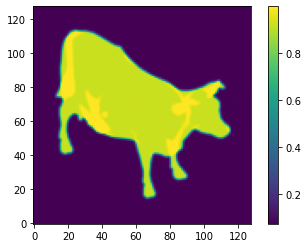

In [5]:
plt.imshow(silhouette.T, origin='lower')
plt.colorbar()
plt.show()